In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
from matplotlib.dates import DateFormatter

In [3]:
data_folder = './zipped_data/'
filenames=os.listdir(data_folder)
filenames = [data_folder+i for i in filenames]

In [6]:
df_all = pd.DataFrame()
for filename in filenames[:1]:
    if filename[-3:] != 'csv':
        print(filename[-3:])
        continue
    df=pd.read_csv(filename)
    print('loaded ' + filename)
    df.drop('Unnamed: 0',axis=1,inplace=True)
    df= df[['Time','Trade_Price','Symbol']]
    df['Time']=pd.to_datetime(df['Time'])
    df.rename(columns={'Symbol':'ticker'},inplace=True)
    df.set_index('Time',drop=False,inplace=True)
    df = drop_closed_market(df)
    df = drop_extremes(df)
    curr_ticker = df.iloc[0].ticker
    aggregation = {
        'Trade_Price': 'mean',
        'Trade_Volume': 'sum'  
    }
    df['ticker'] = curr_ticker
    timeperiods = ['1min','10min','30min','1h','3h']
    for t in timeperiods:
        calc_log_return(df,t)
        if t == '1min':
            continue
        calc_volatility(df,t)
    print(f'done with {filename}. saving...')
    save_filename = filename.split('/')[-1].split('_')[0] + '_new_preprocessed.csv'
    df_all = pd.concat([df_all,df.drop('Time',axis=1)])
    print('finished going to the next one')

loaded ./zipped_data/aapl_trade_results.csv


NameError: name 'drop_closed_market' is not defined

In [7]:
df.head()

,Time,Trade_Price,ticker
Time,,,
2020-01-09 04:00:00.062739,2020-01-09 04:00:00.062739,305.19,AAPL
2020-01-09 04:00:00.100820,2020-01-09 04:00:00.100820,305.19,AAPL
2020-01-09 04:00:00.327003,2020-01-09 04:00:00.327003,305.00,AAPL
2020-01-09 04:00:00.359037,2020-01-09 04:00:00.359037,305.02,AAPL
2020-01-09 04:00:02.766816,2020-01-09 04:00:02.766816,305.19,AAPL


# Closed Market

In [7]:
def drop_closed_market(df):
    hour = df.Time.dt.hour
    minute = df.Time.dt.minute
    hour_mask = (9<=hour) & (hour< 17) 
    weekend_mask = df.Time.dt.dayofweek < 5 # sat = 5, sun = 6
    mask = weekend_mask & hour_mask
    first_half_hour_mask = (hour==9) & (minute<30)
    last_half_hour_mask = (hour==16) & (minute>30)
    mask = mask & ~(first_half_hour_mask | last_half_hour_mask)
    return df[mask]

In [8]:
df_market = drop_closed_market(df)
one_day_mask = (df_market.Time.dt.day == 9)
one_day_mask_df = (df.Time.dt.day == 9)
two_day_mask_market = (df_market.Time.dt.day <= 10)

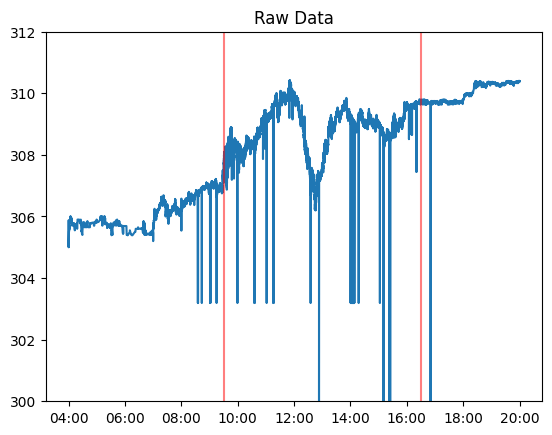

In [9]:
fig, ax = plt.subplots()

ax.plot(df.Time[one_day_mask_df],df.Trade_Price[one_day_mask_df])
plt.ylim([300,312])
#plt.xlim([pd.to_datetime('2020-01-09 09:00'),pd.to_datetime('2020-01-09 18:00')])
myFmt = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(myFmt)
plt.axvline(pd.to_datetime('2020-01-09 09:30'),color='r',alpha=0.5)
plt.axvline(pd.to_datetime('2020-01-09 16:30'),color='r',alpha=0.5)
plt.title('Raw Data')
plt.show()

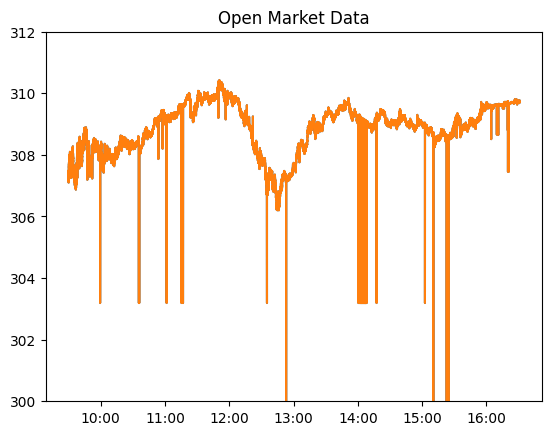

In [10]:
fig, ax = plt.subplots()

plt.plot(df_market.Time[one_day_mask],df_market.Trade_Price[one_day_mask])
plt.plot(df_market.Time[one_day_mask],df_market.Trade_Price[one_day_mask])

plt.ylim([300,312])
myFmt = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(myFmt)
plt.title('Open Market Data')
plt.show()

# Extremes

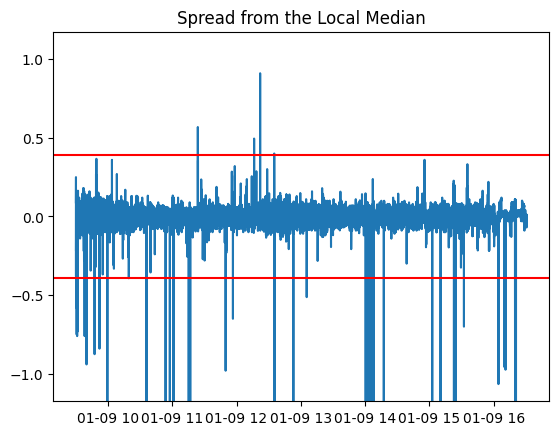

In [11]:
rolling_median = df_market[one_day_mask].Trade_Price.rolling(100).median()
median_spread = df_market[one_day_mask].Trade_Price-rolling_median
mean_median_spread = np.abs(median_spread).mean()

plt.plot(df_market[one_day_mask].Trade_Price-rolling_median)
plt.axhline(mean_median_spread*10,color='r')
plt.axhline(-mean_median_spread*10,color='r')
plt.ylim([-mean_median_spread*30,mean_median_spread*30])

plt.title('Spread from the Local Median')
plt.show()

In [12]:
def drop_extremes(df):
    rolling_median = df.Trade_Price.rolling(100).median()
    median_spread = df.Trade_Price-rolling_median
    mean_median_spread = np.abs(median_spread).mean()
    spread_mask = np.abs(median_spread) < mean_median_spread*10
    return df[spread_mask]

In [13]:
df_extreme = drop_extremes(df_market)
two_day_mask = (df_extreme.Time.dt.day <= 10)

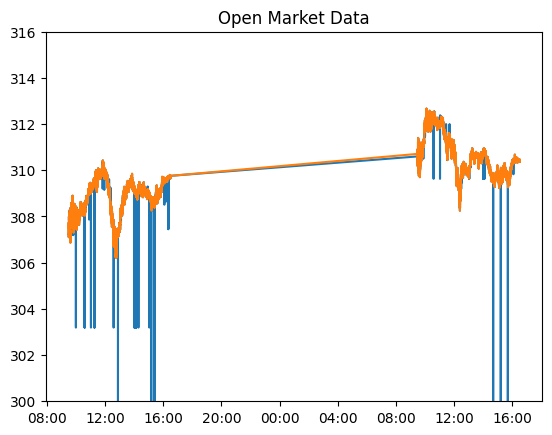

In [14]:
f, ax= plt.subplots()

ax.plot(df_market.Time[two_day_mask_market],df_market.Trade_Price[two_day_mask_market])
ax.plot(df_extreme.Time[two_day_mask],df_extreme.Trade_Price[two_day_mask])

plt.ylim([300,316])
myFmt = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(myFmt)
plt.title('Open Market Data')
plt.show()

# Features

In [19]:
def calc_log_return(df,timescale):
    if 'Log_Return' not in df.columns:
        log_price = np.log(df.Trade_Price)
        log_return = log_price-log_price.shift()
        df['Log_Return'] = log_return
        overnight_indices = df.Time.dt.day.diff().to_numpy().nonzero()[0]
        df.drop(df.index[overnight_indices],inplace=True)
    log_return = df['Log_Return']
    df['log_'+timescale] = log_return.rolling(timescale).sum()


In [20]:
def calc_volatility(df,timescale):
    log_return_str = 'log_'+timescale
    if log_return_str not in df.columns:
        calc_log_return(df)
    volatility = df[log_return_str].rolling(timescale,min_periods=5).std()
    df['volatility_'+log_return_str] = volatility

In [36]:
timeperiods = ['1min','10min','30min','1h','3h']
for t in timeperiods:
    calc_log_return(df_extreme,t)
   # calc_volatility(df_resample,t)
two_day_mask = (df_extreme.Time.dt.day <= 10)

/tmp/ipykernel_73631/3299521684.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_'+timescale] = log_return.rolling(timescale).sum()


In [23]:
two_day_mask = (df_extreme.Time.dt.day <= 10)

In [28]:
def plot_self_hist(series_str,df_extreme):
    f = plt.figure(figsize=(20,10))
    plt.rc('font', size=15) 
    (ax,ax2)= f.subplots(1,2)
    ax.plot(df_extreme.Time[two_day_mask],df_extreme[series_str][two_day_mask])

    #plt.ylim([300,316])
    myFmt = DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(myFmt)
    ax2.hist(df_extreme[series_str][two_day_mask],bins=100)
    #ax2.set_yscale('log')
    plt.suptitle(series_str.upper())
    plt.show()

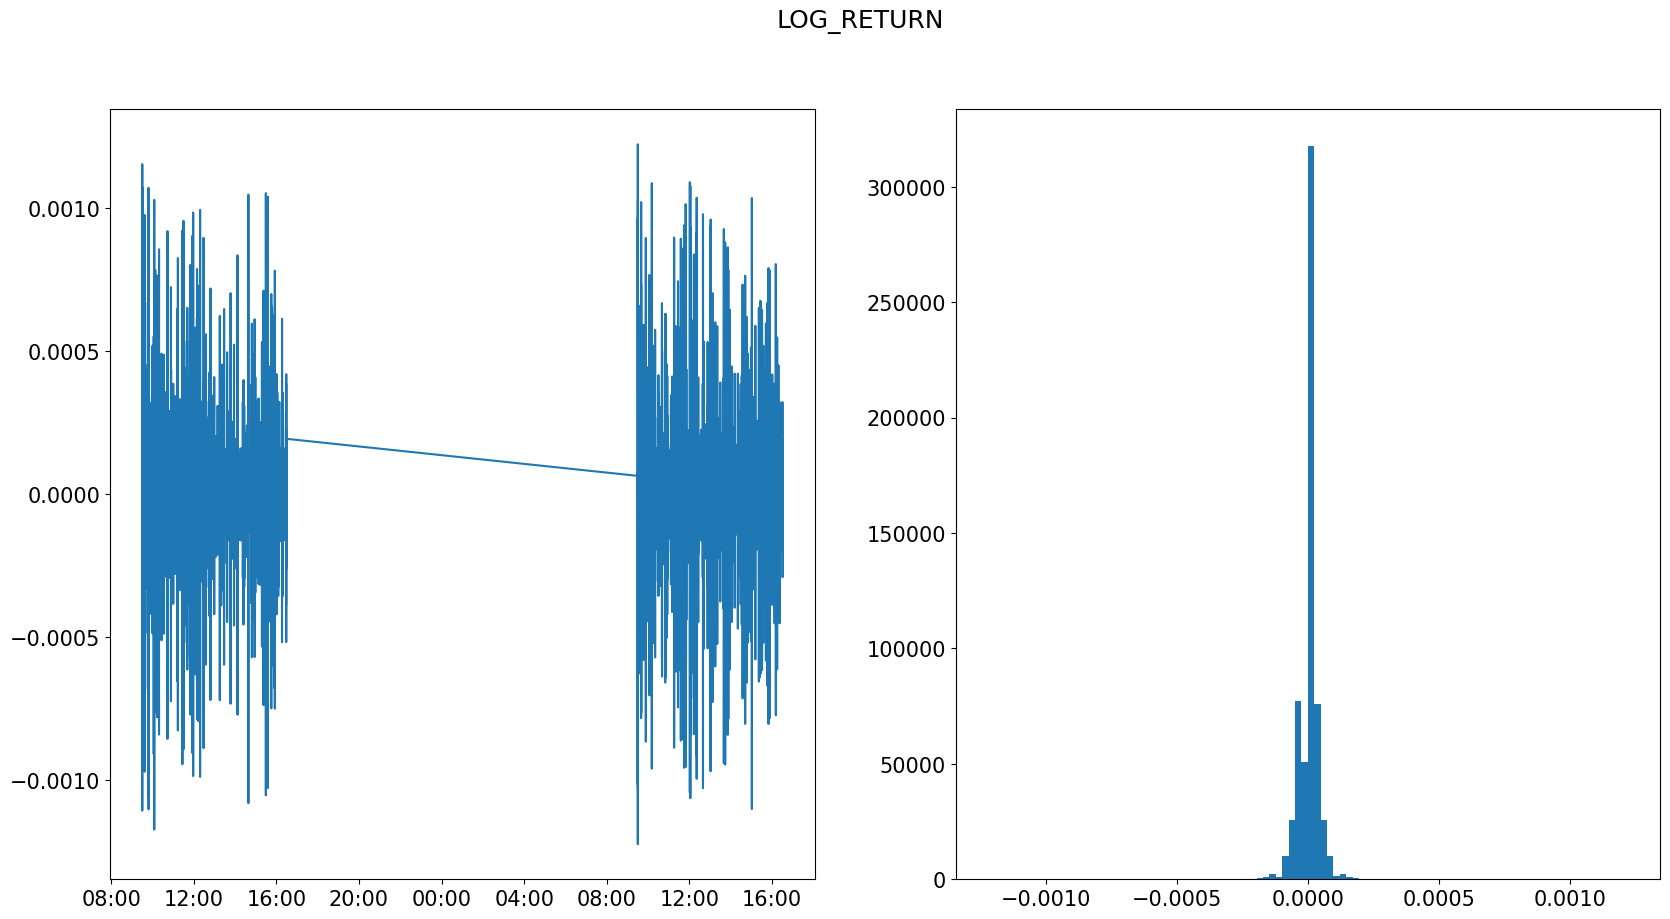

In [29]:
plot_self_hist('Log_Return',df_extreme)

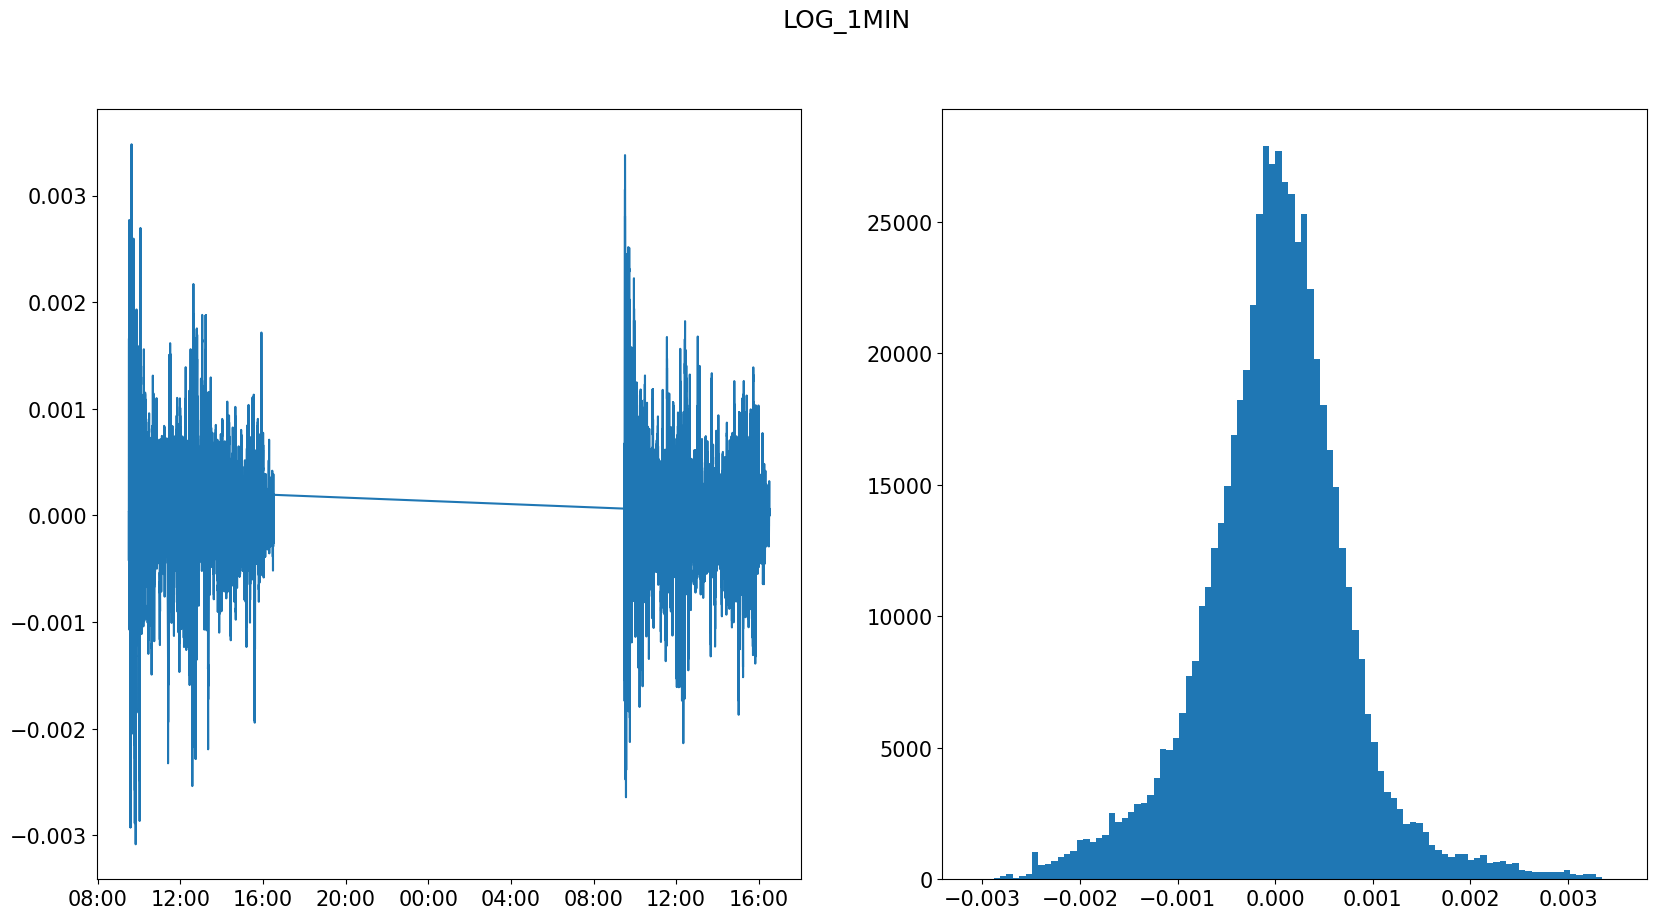

In [30]:
plot_self_hist('log_1min',df_extreme)

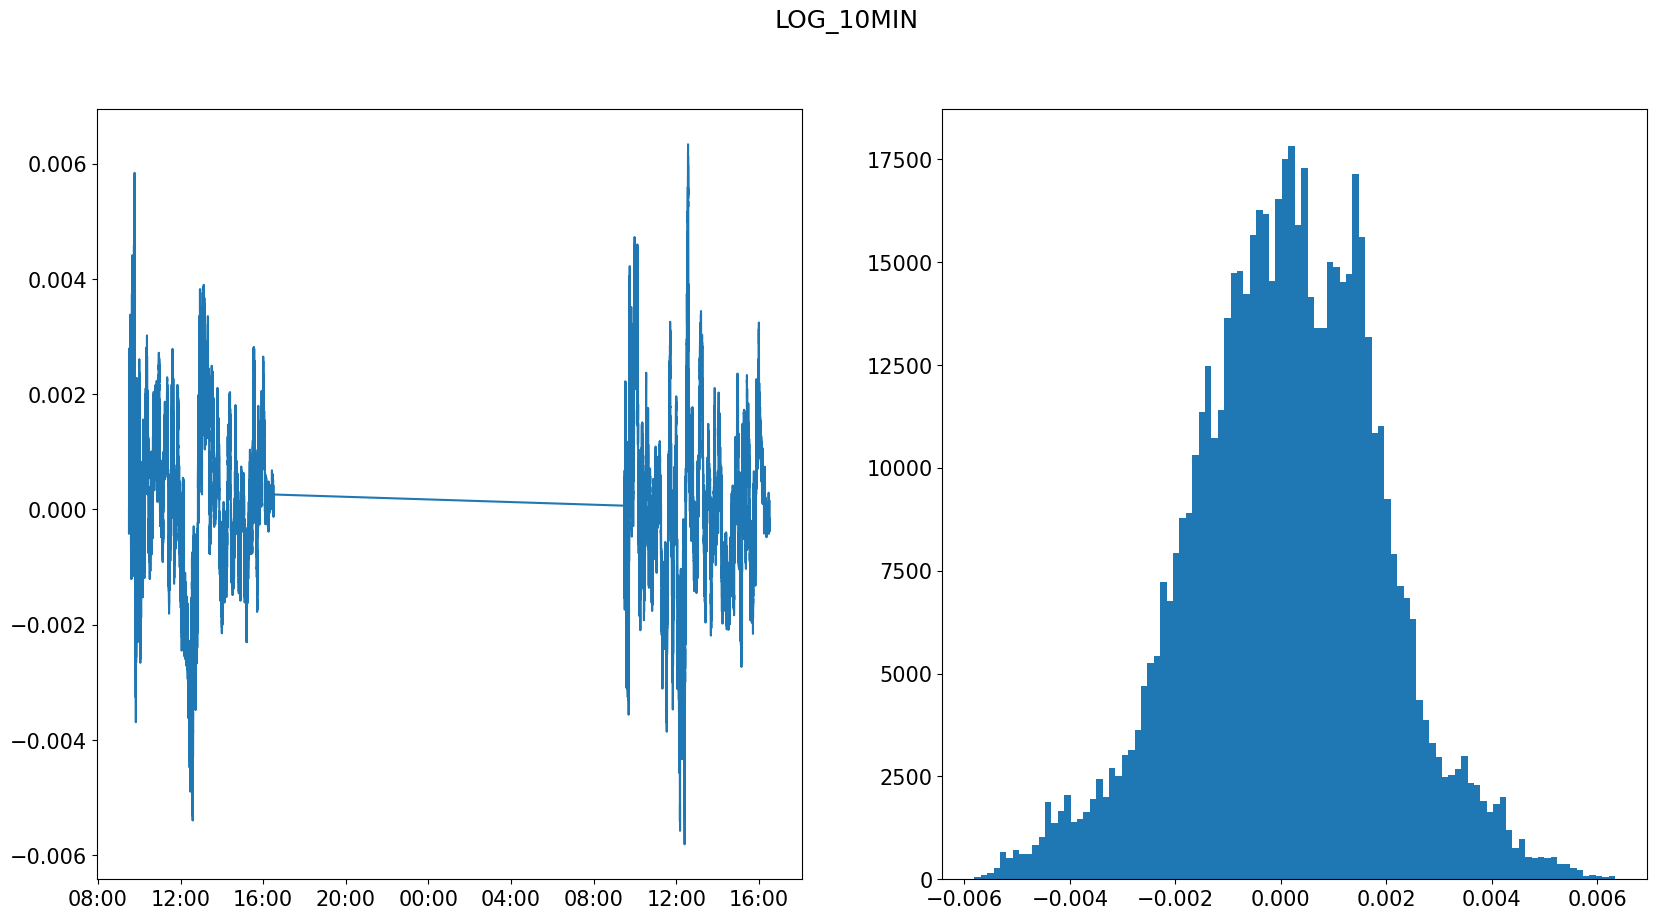

In [33]:
plot_self_hist('log_10min',df_extreme)

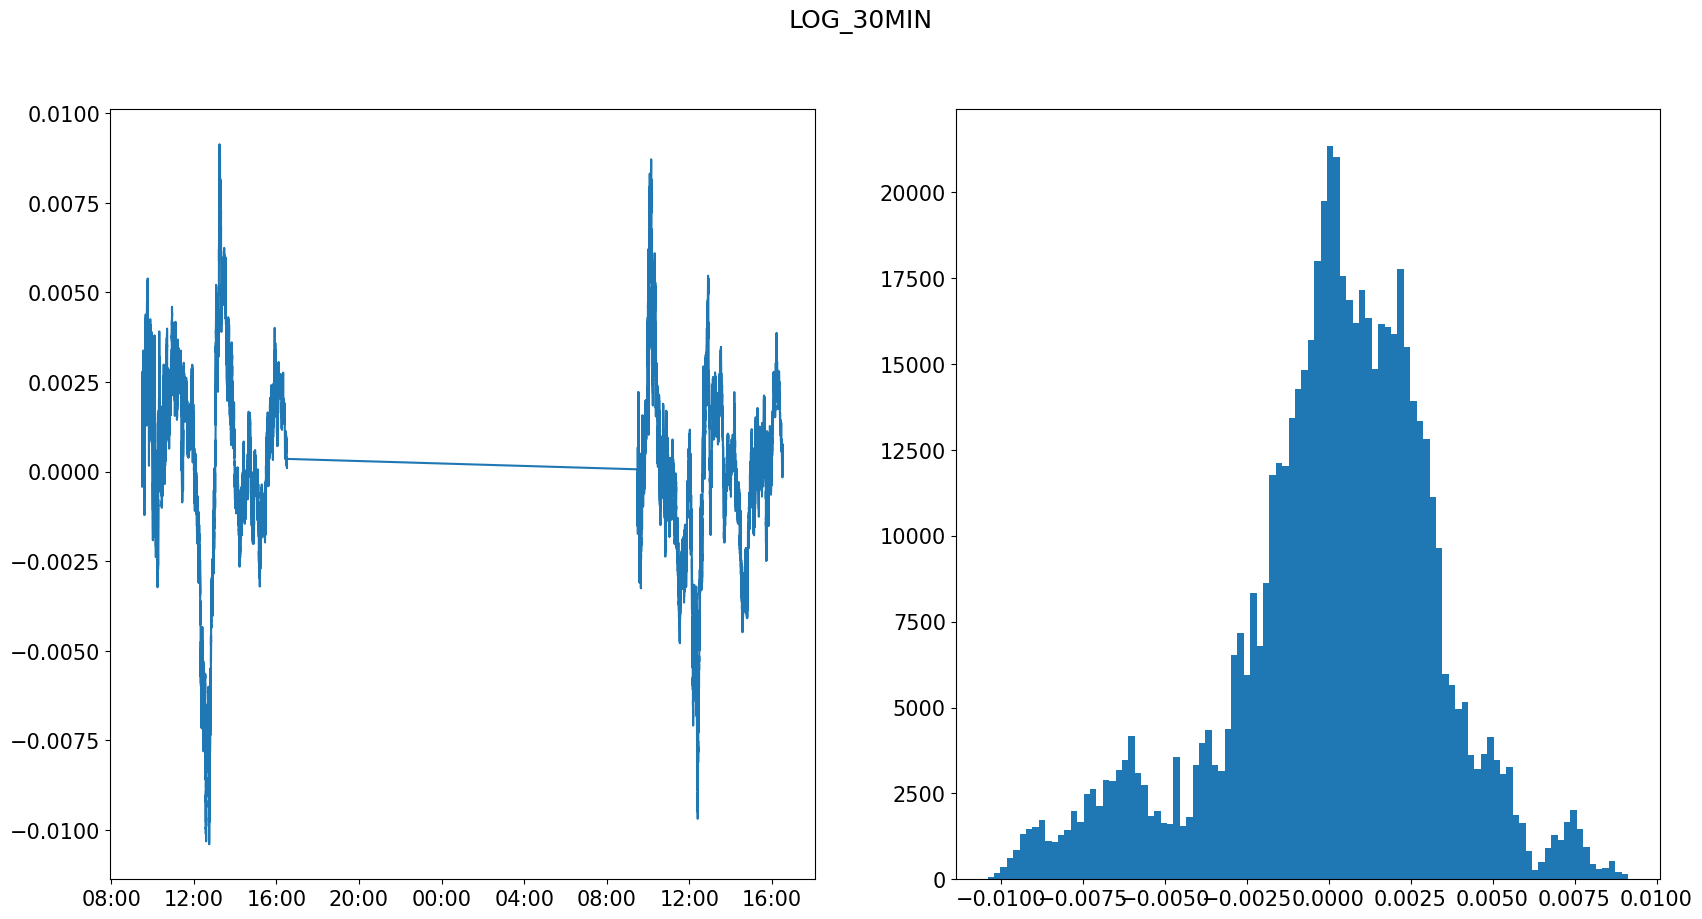

In [37]:
plot_self_hist('log_30min',df_extreme)

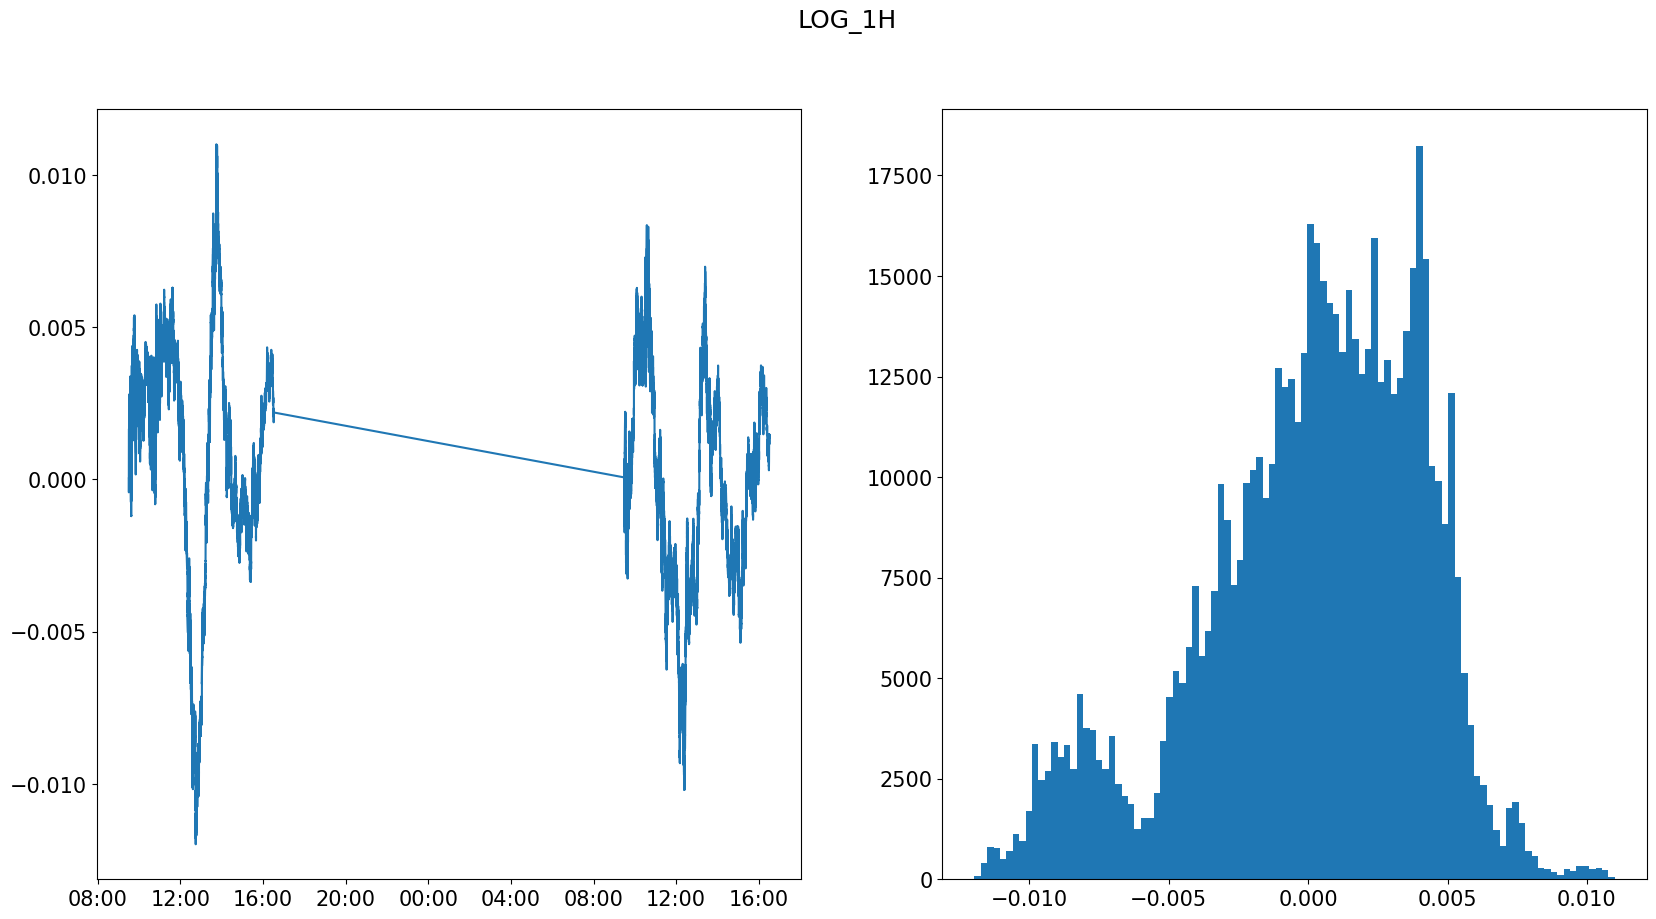

In [38]:
plot_self_hist('log_1h',df_extreme)

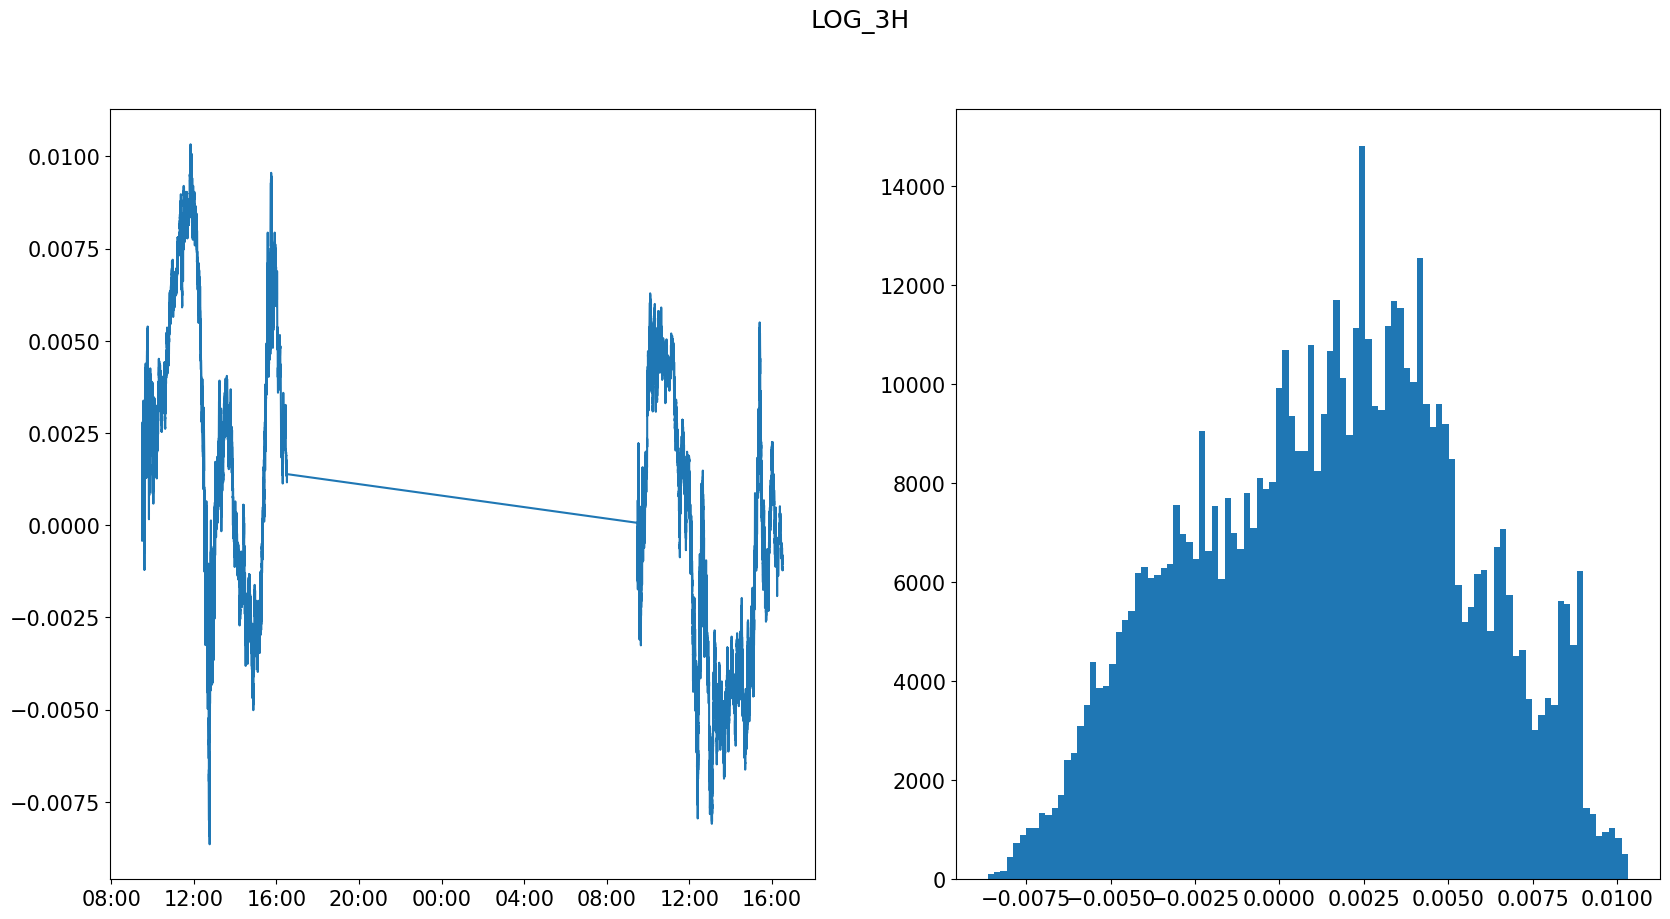

In [39]:
plot_self_hist('log_3h',df_extreme)

# Misc

In [12]:
data_folder = 'prepocessed_data/'
filenames=os.listdir(data_folder)
filenames = [data_folder+i for i in filenames]

In [14]:
for f in filenames:
    if f[-3:] != 'csv':
        continue 
    

prepocessed_data/jpm_preprocessed.csv
prepocessed_data/aapl_preprocessed.csv
prepocessed_data/msft_preprocessed.csv
prepocessed_data/tsla_preprocessed.csv
prepocessed_data/nvda_preprocessed.csv
prepocessed_data/goog_preprocessed.csv
prepocessed_data/unh_preprocessed.csv
prepocessed_data/amzn_preprocessed.csv


In [34]:
df1= pd.read_csv('prepocessed_data/jpm_preprocessed.csv',nrows=300_000)
df2= pd.read_csv('prepocessed_data/msft_preprocessed.csv',nrows= 300_000)

In [35]:
df3= pd.concat([df1,df2])

In [37]:
df3.sort_values('Time',inplace=True)

In [38]:
df3.to_csv('jpm_msft.csv')